In [429]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression as LRG
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt

import matplotlib.ticker as mticker


from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

from scipy.interpolate import interp1d


import pickle

from utils import (get_unique_elements,
                   get_all_costs,
                   compute_rec_man_ratio,
                   submodular_function,
                   probablistic_submodular_function,
                   greedy_submodular_minimization,
                   greedy_probablistic_submodular_minimization,
                   greedy_probablistic_pair_submodular_minimization,
                   greedy_pair_submodular_minimization,
                   X_opt_set_cost,
                   compute_utils,
                   social_cost,
                   calculate_mean_std,
                   calculate_mean_std_recourse_rate_diff,
                   #save_dictionaries_as_pickle
    
)


# Loading dataset

In [432]:
from helper import FileInfo

from sklearn.linear_model import LogisticRegression as LRG

import pandas

names = ['recid', 'adult', 'crime', 'law', 'student', 'german']

classifier_names = ['logistic_regression', 'GradientBoostingClassifier']



## Choose classifier and dataset

In [447]:
dataset_name = 'german'
classifier_name = 'logistic_regression' # 'gbc'

In [449]:
name_index = names.index(dataset_name)

sense_f = 'race' if name_index <= 3 else 'gender'
fileInfo = FileInfo(sense_f=sense_f)
X, y, A = fileInfo.prep(f_index=name_index + 1, groups=True, remove_sense=False, numpy= False, scaling='both', even_lables = True)


y = y.to_numpy()
A = A.to_numpy()
X = X.to_numpy()


X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, train_size=0.75)


if classifier_name == 'logistic_regression':
    clf = LRG(max_iter = 10_000).fit(X_train, y_train)
else:
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
       max_depth=1, random_state=0).fit(X_train, y_train)
    
    

full_pred = clf.predict(X)
test_pred = clf.predict(X_test)

X_pos_full = X_test[test_pred == 1] # set of all positively classified features
y_pos_full = y_test[test_pred == 1] # get the corresponding y_pos_full
A_pos_full = A_test[test_pred == 1] # get the corresponding A_pos_full


X_neg_full = X_test[test_pred == 0] # set of all negatively classified features (these should be the agents)
y_neg_full = y_test[test_pred == 0] # get the corresponding y_neg
A_neg_full = A_test[test_pred == 0] # get the corresponding A_neg



# Concatenate the positive and negative datasets
X_combined = np.vstack((X_pos_full, X_neg_full))
y_combined = np.concatenate((y_pos_full, y_neg_full))

# Make predictions using the classifier
y_pred = clf.predict(X_combined)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_combined, y_pred)

# Extract the values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

print(tn, fp, fn, tp)







removed features: []
134 40 51 125


In [451]:
num_samps_pos = 40


print("num_samps_pos", num_samps_pos)

# generate X_pos and X_opt
X_pos_index = np.random.choice(np.arange(X_pos_full.shape[0]), size = num_samps_pos, replace = False)
X_pos = X_pos_full[X_pos_index]
y_pos = y_pos_full[X_pos_index]



# also downsample X_neg for the adult dataset

num_samps_neg = 100

print("num_samps_neg", num_samps_neg)


X_neg_index = np.random.choice(np.arange(X_neg_full.shape[0]), size = num_samps_neg, replace = False)
X_neg = X_neg_full[X_neg_index]
y_neg = y_neg_full[X_neg_index]
A_neg = A_neg_full[X_neg_index]

num_samps_pos 40
num_samps_neg 100


## Helper functions

In [454]:
def diff_social_cost_group(revealed_set, input_X_pos_cR, input_X_pos_cM, X_neg, A_neg):
 
    # Get the indices of elements whose race is 0
    indices_zero = np.where(A_neg == 0)

    # Get the indices of elements whose race is 1
    indices_one = np.where(A_neg == 1)

    # Use the mask to select the rows that satisfy the condition
    X_neg_race0 = X_neg[indices_zero]
    X_neg_race1 = X_neg[indices_one]
    
    
    social_cost0 = social_cost(revealed_set, input_X_pos_cR, input_X_pos_cM, X_neg_race0)
    social_cost1 = social_cost(revealed_set, input_X_pos_cR, input_X_pos_cM, X_neg_race1)    
    
    return np.abs(social_cost0 - social_cost1)
    

In [456]:
def diff_recourse_access(revealed_set, input_X_pos_cR, input_X_pos_cM, X_neg, A_neg):
    
    # Get the indices of elements whose race is 0
    indices_zero = np.where(A_neg == 0)

    # Get the indices of elements whose race is 1
    indices_one = np.where(A_neg == 1)

    # Use the mask to select the rows that satisfy the condition
    X_neg_race0 = X_neg[indices_zero]
    X_neg_race1 = X_neg[indices_one]
     
    
    # recourse ratio for race0
    rec_ratio0, _ = compute_rec_man_ratio(X_neg_race0, X_pos, revealed_set, input_X_pos_cR, input_X_pos_cM)
    rec_ratio1, _ = compute_rec_man_ratio(X_neg_race1, X_pos, revealed_set, input_X_pos_cR, input_X_pos_cM)
    
#     print(rec_ratio0)
#     print(rec_ratio1)
    
    return np.abs(rec_ratio0 - rec_ratio1)

## Run the experiments

In [445]:
total_run = 100

In [419]:
cost_scaling_factor = 10


#subs_list = [0, 0.2, 0.4, 0.6, 0.8, 1]
#subs_list = [0.1, 0.25, 0.3, 0.35]


subs_list = [0,  0.2, 0.4, 0.5, 0.6, 0.8, 1]

prob = 0.7


# create a dictionary for each plot to generate plots with error bars

rec_ratio_result_dict = {}
man_ratio_result_dict = {}

utility_result_dict = {}

social_cost_result_dict = {}

rec_ratio_diff_result_dict = {}
social_cost_diff_result_dict = {}


for iteration in range(total_run):
    print(iteration)
    
    # generate coefficient for each dataset
    # law
    # w_R = cost_scaling_factor * np.random.uniform(0.3, 0.9, size = X_neg[0].shape[0])
    # w_M = cost_scaling_factor * 0.65 * np.random.uniform(0.2 , 1, size = X_neg[0].shape[0])

    # Adult 
    w_R = cost_scaling_factor * np.random.uniform(0.3, 0.9, size = X_neg[0].shape[0])
    w_M = cost_scaling_factor * 0.75 * np.random.uniform(0 , 1, size = X_neg[0].shape[0])

    # # German
    # w_R = cost_scaling_factor * np.random.uniform(0.1, 1, size = X_neg[0].shape[0])
    # w_M = cost_scaling_factor * 0.9 * np.random.uniform(0.2 , 1, size = X_neg[0].shape[0])
 
    # generate X_opt by downsample X_pos_full
    X_pos_index = np.random.choice(np.arange(X_pos_full.shape[0]), size = num_samps_pos, replace = False)
    X_pos = X_pos_full[X_pos_index]
    y_pos = y_pos_full[X_pos_index]

    # generate the cost after down-sample
    X_pos_cR, X_pos_cM = get_all_costs(X_neg, X_pos, w_R, w_M)


    # compute the optimal recourse set and generate its corresponding cost dictionary
    X_opt, X_opt_cR, X_opt_cM, rec_list_dict = X_opt_set_cost(X_neg, X_pos, X_pos_cR, X_pos_cM)

    # then downsample X_pos_full to generate X_pos for the sake of compute utility
    
    # generate one run over all subsidies
    for sub in subs_list:
        print("sub", sub)

        # adjust the cost for subsidy

        X_opt_cR_subs = {key: value * (1 - sub) for key, value in X_opt_cR.items()}   

        selected_subset_sequence = greedy_probablistic_pair_submodular_minimization(X_neg, X_opt, X_opt_cR_subs, X_opt_cM, 
                                                               probablistic_submodular_function, prob, len(X_opt))  
        provide_rec = np.zeros(len(X_neg))


        # generate results
        
        rec_ratio_result_list = []
        man_ratio_result_list = []

        utility_result_list = []

        social_cost_result_list = []

        rec_ratio_diff_result_list = []
        social_cost_diff_result_list = []

        for i in range(0, len(X_opt) - 1):


            selected_subset = selected_subset_sequence[:i+1]
            #print(selected_subset)

            index = get_unique_elements(rec_list_dict[ele] for ele in selected_subset)
         #   print("index", index)
            
            provide_rec = [1 if ii in index else 0 for ii in range(len(X_neg))]
            
            num_rec_provided = np.sum(provide_rec)

            # recourse ratio, manipulation ratio, and system utility      
            rec_ratio, man_ratio, utility_result = compute_utils(selected_subset, X_opt, X_opt_cR_subs, X_opt_cM, clf, X_neg, y_neg, X_pos, y_pos, provide_rec)

            # social cost
            social_cost_result = social_cost(selected_subset, X_opt_cR_subs, X_opt_cM, X_neg)


            # fairness disparity
            rec_ratio_diff = diff_recourse_access(selected_subset, X_opt_cR_subs, X_opt_cM, X_neg, A_neg)
            social_cost_diff = diff_social_cost_group(selected_subset, X_opt_cR_subs, X_opt_cM, X_neg, A_neg)



            # rec_ratio_result_list.append((num_rec_provided, rec_ratio))
            # man_ratio_result_list.append((num_rec_provided, man_ratio))

            utility_result_list.append((num_rec_provided,utility_result))

#             social_cost_result_list.append((num_rec_provided,social_cost_result))

#             rec_ratio_diff_result_list.append((num_rec_provided,rec_ratio_diff))
#             social_cost_diff_result_list.append((num_rec_provided,social_cost_diff))
    
    
    
        # rec_ratio_result_dict[iteration, sub] = rec_ratio_result_list
        # man_ratio_result_dict[iteration, sub] = man_ratio_result_list

        utility_result_dict[iteration, sub] = utility_result_list

#         social_cost_result_dict[iteration, sub] = social_cost_result_list

#         rec_ratio_diff_result_dict[iteration, sub] = rec_ratio_diff_result_list
#         social_cost_diff_result_dict[iteration, sub] = social_cost_diff_result_list
    


0
sub 0
sub 0.2
sub 0.23
sub 0.25
sub 0.28
sub 0.3
sub 0.325
sub 0.35
sub 0.375
sub 0.4
sub 0.6
sub 0.8
sub 1
1
sub 0
sub 0.2
sub 0.23
sub 0.25
sub 0.28
sub 0.3
sub 0.325
sub 0.35
sub 0.375
sub 0.4
sub 0.6
sub 0.8
sub 1
2
sub 0
sub 0.2
sub 0.23
sub 0.25
sub 0.28
sub 0.3
sub 0.325
sub 0.35
sub 0.375
sub 0.4
sub 0.6
sub 0.8
sub 1
3
sub 0
sub 0.2
sub 0.23
sub 0.25
sub 0.28
sub 0.3
sub 0.325
sub 0.35
sub 0.375
sub 0.4
sub 0.6
sub 0.8
sub 1
4
sub 0
sub 0.2
sub 0.23
sub 0.25
sub 0.28
sub 0.3
sub 0.325
sub 0.35
sub 0.375
sub 0.4
sub 0.6
sub 0.8
sub 1
5
sub 0
sub 0.2
sub 0.23
sub 0.25
sub 0.28
sub 0.3
sub 0.325
sub 0.35
sub 0.375
sub 0.4
sub 0.6
sub 0.8
sub 1
6
sub 0
sub 0.2
sub 0.23
sub 0.25
sub 0.28
sub 0.3
sub 0.325
sub 0.35
sub 0.375
sub 0.4
sub 0.6
sub 0.8
sub 1
7
sub 0
sub 0.2
sub 0.23
sub 0.25
sub 0.28
sub 0.3
sub 0.325
sub 0.35
sub 0.375
sub 0.4
sub 0.6
sub 0.8
sub 1
8
sub 0
sub 0.2
sub 0.23
sub 0.25
sub 0.28
sub 0.3
sub 0.325
sub 0.35
sub 0.375
sub 0.4
sub 0.6
sub 0.8
sub 1
9
sub 0
su

In [76]:
# Store dictionaries in a dictionary with their desired names as keys
dictionaries = {
    'rec_ratio_result_dict': rec_ratio_result_dict,
    'man_ratio_result_dict': man_ratio_result_dict,
    'utility_result_dict': utility_result_dict,
    'social_cost_result_dict': social_cost_result_dict,
    'rec_ratio_diff_result_dict': rec_ratio_diff_result_dict,
    'social_cost_diff_result_dict':social_cost_diff_result_dict
}


def save_dictionaries_as_pickle(dicts, dataset_name, classifier_name):
    for dict_name, dict_data in dicts.items():
        if classifier_name == 'logistic_regression':
            filename = f"{dataset_name}_logistic_regression_{dict_name}.pkl"
        else:
            filename = f"{dataset_name}_gbc_{dict_name}.pkl"
            
        with open(filename, 'wb') as file:
            pickle.dump(dict_data, file)
        print(f"Saved: {filename}")

# Save the dictionaries as pickle files
save_dictionaries_as_pickle(dictionaries, dataset_name, classifier_name)




Saved: german_logistic_regression_rec_ratio_result_dict.pkl
Saved: german_logistic_regression_man_ratio_result_dict.pkl
Saved: german_logistic_regression_utility_result_dict.pkl
Saved: german_logistic_regression_social_cost_result_dict.pkl
Saved: german_logistic_regression_rec_ratio_diff_result_dict.pkl
Saved: german_logistic_regression_social_cost_diff_result_dict.pkl


In [425]:
# TODO: save this multirun utility_result_dict

additional_utility_dictionaries = {
    'additional_utility_result_dict': utility_result_dict,
}


# Save the dictionaries as pickle files
save_dictionaries_as_pickle(additional_utility_dictionaries, dataset_name, classifier_name)



Saved: law_logistic_regression_additional_utility_result_dict.pkl


{0: 4.08, 0.2: 3.8, 0.23: 3.11, 0.25: 3.43, 0.28: 3.24, 0.3: 3.28, 0.325: 3.38, 0.35: 88.95931034482761, 0.375: 94.74, 0.4: 94.57, 0.6: 94.79, 0.8: 95.09, 1: 95.18}
{0: 95.19, 0.2: 95.0, 0.23: 95.18, 0.25: 95.21, 0.28: 95.17, 0.3: 95.09, 0.325: 95.66, 0.35: 95.32, 0.375: 94.74, 0.4: 94.57, 0.6: 94.79, 0.8: 95.09, 1: 95.18}


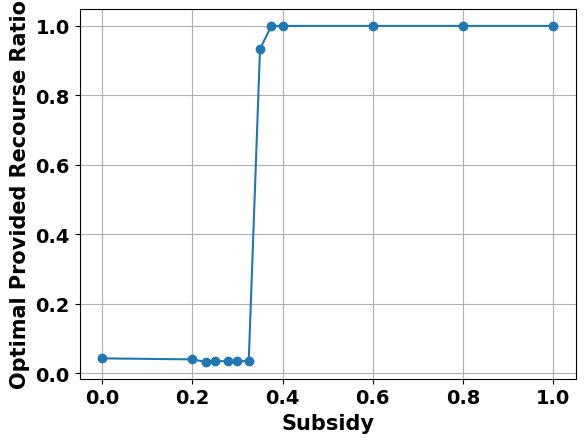

In [427]:
means, std_devs = calculate_mean_std(utility_result_dict)

# Find the optimal ratio for each key 
# the form of mean is: key = subsidy level, value = {[precent of population with provided recourse, utility]...}
'''
{0: {[4, 19],
    [8, 14],
    ...}
0.2: {[2, 10],
    [6, 34],
    ...}
...
1: {[2, 10],
    [6, 34],
    ...}   
}
'''
optimal_ratios = {}
for key, value in means.items():
    optimal_ratio = max(value, key=lambda x: x[1])[0]
    optimal_ratios[key] = optimal_ratio
    
print(optimal_ratios)
# Get the ratio in the last value of each key
last_ratios = {key: value[-1][0] for key, value in means.items()}

print(last_ratios)

# Normalize the optimal ratios by the last ratio in the value
normalized_ratios = {key: optimal_ratios[key] / last_ratios[key] for key in optimal_ratios}

# Plot the normalized optimal ratio as a function of the key
keys = list(normalized_ratios.keys())
ratios = list(normalized_ratios.values())


plt.plot(keys, ratios, marker='o')

plt.xlabel('Subsidy', fontsize=15, fontweight='bold')
plt.ylabel('Optimal Provided Recourse Ratio', fontsize=15, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')



plt.grid(True)


# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_max_utility_rec_provided_rate.png")

plt.show()

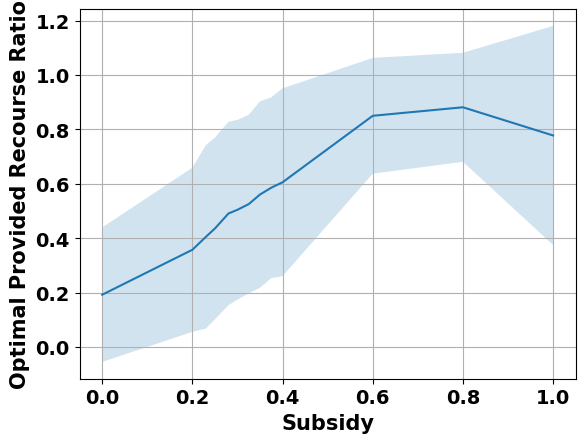

In [423]:
# Find the optimal ratio for each key (iteration, subsidy)
optimal_ratios = {}

for key, value in utility_result_dict.items():
    # Find the tuple with the maximum second quantity
    max_tuple = max(value, key=lambda x: x[1])
    # Get the first quantity corresponding to the maximum second quantity
    max_provided_rec_ratio = max_tuple[0]
    # Get the last first quantity in the value
    last_provided_rec_ratio = value[-1][0]
    # Calculate the normalized value
    normalized_value = max_provided_rec_ratio / last_provided_rec_ratio
    # Update the new dictionary
    optimal_ratios[key] = normalized_value
    
# Group the ratios by subsidy value
subsidy_values = {}
for key, ratio in optimal_ratios.items():
    _, subsidy = key
    if subsidy not in subsidy_values:
        subsidy_values[subsidy] = []
    subsidy_values[subsidy].append(ratio)

# Calculate the mean and standard deviation of the ratios for each subsidy
subsidies = sorted(subsidy_values.keys())
means = [np.mean(subsidy_values[subsidy]) for subsidy in subsidies]

std_devs = [np.std(subsidy_values[subsidy]) for subsidy in subsidies]

plt.plot(subsidies, means)
plt.fill_between(subsidies, [a - b for a, b in zip(means, std_devs)], [a + b for a, b in zip(means, std_devs)], alpha = 0.2)


plt.xlabel('Subsidy', fontsize=15, fontweight='bold')
plt.ylabel('Optimal Provided Recourse Ratio', fontsize=15, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.grid(True)


# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_max_utility_rec_provided_rate_multiple_runs.png")

plt.show()


# Import pickle files (dictionaries) and plots

In [558]:
# dictionaries = {
#         'rec_ratio_result_dict': rec_ratio_result_dict,
#         'man_ratio_result_dict': man_ratio_result_dict,
#         'utility_result_dict': utility_result_dict,
#         'social_cost_result_dict': social_cost_result_dict,
#         'rec_ratio_diff_result_dict': rec_ratio_diff_result_dict,
#         'social_cost_diff_result_dict':social_cost_diff_result_dict
#     }

dictionary_names = ['rec_ratio_result_dict',
                    'man_ratio_result_dict',
                    'utility_result_dict',
                    'social_cost_result_dict',
                    'rec_ratio_diff_result_dict',
                    'social_cost_diff_result_dict'  
                   ]

In [500]:
# def load_pickled_dictionaries(big_dictionary, dataset_name):
#     loaded_dictionaries = {}

#     for dict_name, _ in big_dictionary.items():
#         filename = f"{dataset_name}_logistic_regression_{dict_name}.pkl"
#         with open(filename, 'rb') as file:
#             loaded_dictionary = pickle.load(file)
#             loaded_dictionaries[dict_name] = loaded_dictionary
#             print(f"Loaded: {filename}")

#     return loaded_dictionaries

def load_pickled_dictionaries(dictionary_names, dataset_name, classifier_name):
    loaded_dictionaries = {}

    for dict_name in dictionary_names:
        if classifier_name == 'logistic_regression':
            filename = f"{dataset_name}_logistic_regression_{dict_name}.pkl"
        else:
            filename = f"{dataset_name}_gradient_boosting_classifier_{dict_name}.pkl"
            
        with open(filename, 'rb') as file:
            loaded_dictionary = pickle.load(file)
            loaded_dictionaries[dict_name] = loaded_dictionary
            print(f"Loaded: {filename}")

    return loaded_dictionaries

In [845]:
dataset_name = 'german'  # Replace with your actual dataset name

# Load the dictionaries from pickle files
loaded_dictionaries = load_pickled_dictionaries(dictionary_names, dataset_name, classifier_name)


Loaded: german_logistic_regression_rec_ratio_result_dict.pkl
Loaded: german_logistic_regression_man_ratio_result_dict.pkl
Loaded: german_logistic_regression_utility_result_dict.pkl
Loaded: german_logistic_regression_social_cost_result_dict.pkl
Loaded: german_logistic_regression_rec_ratio_diff_result_dict.pkl
Loaded: german_logistic_regression_social_cost_diff_result_dict.pkl


In [847]:
loaded_dictionaries.keys()

dict_keys(['rec_ratio_result_dict', 'man_ratio_result_dict', 'utility_result_dict', 'social_cost_result_dict', 'rec_ratio_diff_result_dict', 'social_cost_diff_result_dict'])

In [849]:
for keys, values in loaded_dictionaries.items():
    
    rec_ratio_result_dict =loaded_dictionaries['rec_ratio_result_dict']
    man_ratio_result_dict = loaded_dictionaries['man_ratio_result_dict']
    utility_result_dict = loaded_dictionaries['utility_result_dict']
    social_cost_result_dict = loaded_dictionaries['social_cost_result_dict']
    rec_ratio_diff_result_dict = loaded_dictionaries['rec_ratio_diff_result_dict']
    social_cost_diff_result_dict = loaded_dictionaries['social_cost_diff_result_dict']    
    
    

# plotting for each quantities that we care about

<Figure size 640x480 with 0 Axes>

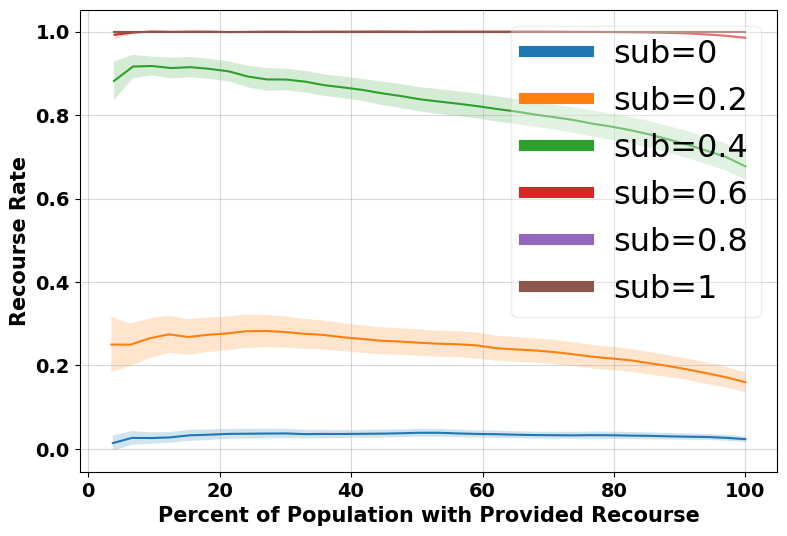

In [852]:
means, std_devs = calculate_mean_std(rec_ratio_result_dict)

plt.figure()  # Create a new figure for each plot

#Plotting with normalized x-axis
plt.figure(figsize=(9, 6))

for sub, mean_values in means.items():
    # Normalizing x-values to percentage
    max_x_value = np.max(mean_values[:, 0])
    x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
    y_values = mean_values[:, 1]
    std_dev = std_devs[sub]

    plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
    plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# Customize the plot
#plt.title('Recourse Rate', fontsize=20, fontweight='bold')
plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
plt.ylabel('Recourse Rate', fontsize=15, fontweight='bold')


# Adding and customizing the legend
legend = plt.legend(fontsize = 23, title_fontsize = 25, framealpha = 0.35, loc='upper right')# Set fontsize for legend labels and title

for line in legend.get_lines():
    line.set_linewidth(8)  # Set the linewidth of the line in the legend
    

# Setting x-axis to specific percentages
#percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
#plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# Customizing the x-axis and y-axis tick labels
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

#plt.legend(fontsize = 20) 


plt.grid('on', alpha = 0.5)

# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_rec_ratio.png")

plt.show()

<Figure size 640x480 with 0 Axes>

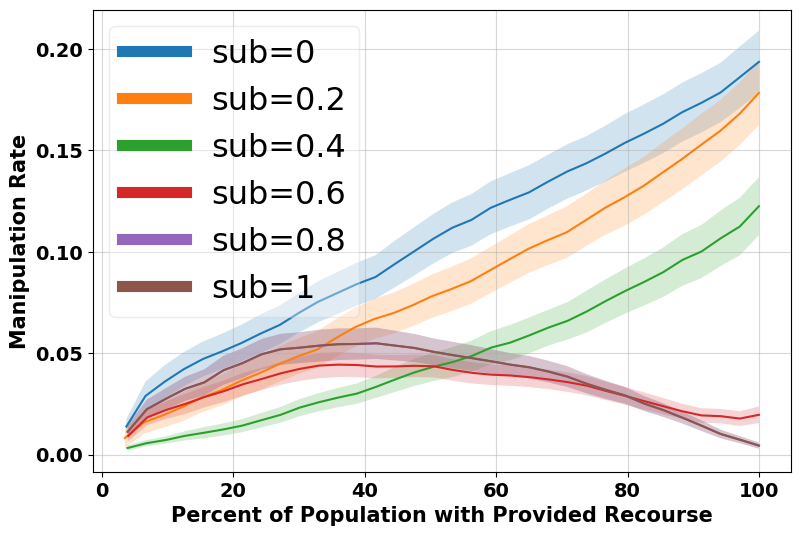

In [855]:
means, std_devs = calculate_mean_std(man_ratio_result_dict)

plt.figure()  # Create a new figure for each plot

#Plotting with normalized x-axis
plt.figure(figsize=(9, 6))

for sub, mean_values in means.items():
    # Normalizing x-values to percentage
    max_x_value = np.max(mean_values[:, 0])
    x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
    y_values = mean_values[:, 1]
    std_dev = std_devs[sub]

    plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
    plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# Customize the plot
#plt.title('Recourse Rate', fontsize=20, fontweight='bold')
plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
plt.ylabel('Manipulation Rate', fontsize=15, fontweight='bold')


# Adding and customizing the legend
legend = plt.legend(fontsize = 23, title_fontsize = 25, framealpha = 0.35, loc='upper left')# Set fontsize for legend labels and title

for line in legend.get_lines():
    line.set_linewidth(8)  # Set the linewidth of the line in the legend
    


#plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    

# Setting x-axis to specific percentages
#percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
#plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# Customizing the x-axis and y-axis tick labels
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')



plt.grid('on', alpha = 0.5)

# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_man_ratio.png")

plt.show()

<Figure size 640x480 with 0 Axes>

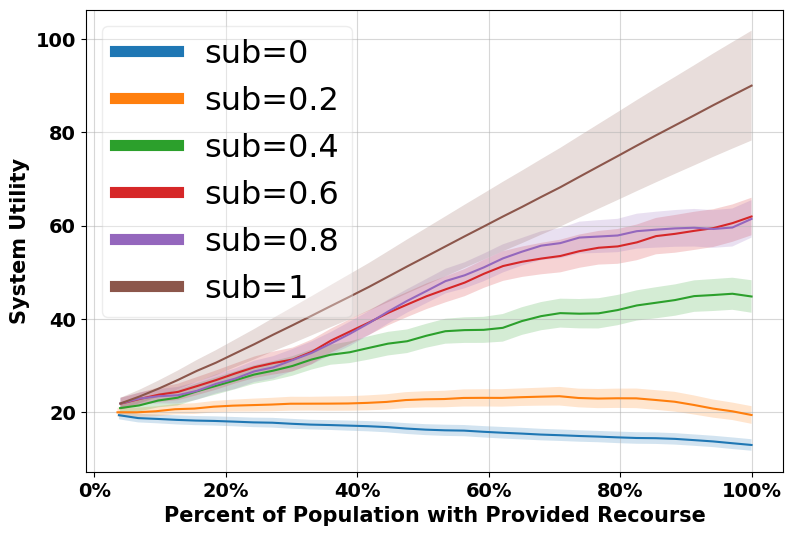

In [856]:
means, std_devs = calculate_mean_std(utility_result_dict)

plt.figure()  # Create a new figure for each plot

#Plotting with normalized x-axis
plt.figure(figsize=(9, 6))

for sub, mean_values in means.items():
    # Normalizing x-values to percentage
    max_x_value = np.max(mean_values[:, 0])
    x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
    y_values = mean_values[:, 1]
    std_dev = std_devs[sub]

    plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
    plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# Customize the plot
#plt.title('Recourse Rate', fontsize=20, fontweight='bold')
plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
plt.ylabel('System Utility', fontsize=15, fontweight='bold')


# Adding and customizing the legend
legend = plt.legend(fontsize = 23, title_fontsize = 25, framealpha = 0.35, loc='upper left')# Set fontsize for legend labels and title

for line in legend.get_lines():
    line.set_linewidth(8)  # Set the linewidth of the line in the legend

plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    

# Setting x-axis to specific percentages
#percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
#plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# Customizing the x-axis and y-axis tick labels
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')


plt.grid('on', alpha = 0.5)

# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_utility.png")

plt.show()

## [05/16/2024] plot max utility's corresponding percent of population with provided recourse as a function of subsidy 

{0: 3.62, 0.2: 68.23606060606065, 0.4: 93.68030303030301, 0.6: 97.19, 0.8: 97.34, 1: 97.34}
{0: 96.76, 0.2: 96.43, 0.4: 96.49, 0.6: 97.19, 0.8: 97.34, 1: 97.34}


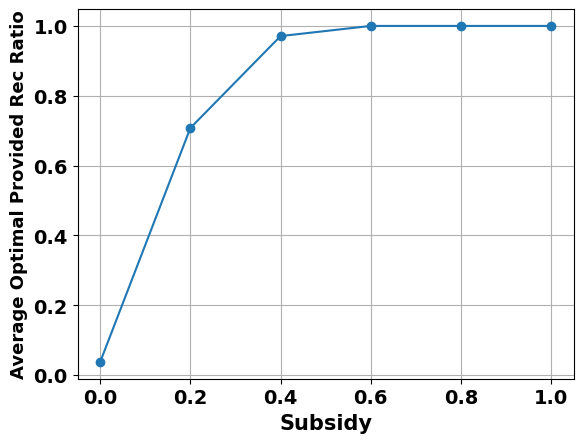

In [861]:
# Find the optimal ratio for each key 
# the form of mean is: key = subsidy level, value = {[precent of population with provided recourse, utility]...}
'''
{0: {[4, 19],
    [8, 14],
    ...}
0.2: {[2, 10],
    [6, 34],
    ...}
...
1: {[2, 10],
    [6, 34],
    ...}   
}
'''
optimal_ratios = {}
for key, value in means.items():
    optimal_ratio = max(value, key=lambda x: x[1])[0]
    optimal_ratios[key] = optimal_ratio
    
print(optimal_ratios)
# Get the ratio in the last value of each key
last_ratios = {key: value[-1][0] for key, value in means.items()}

print(last_ratios)

# Normalize the optimal ratios by the last ratio in the value
normalized_ratios = {key: optimal_ratios[key] / last_ratios[key] for key in optimal_ratios}

# Plot the normalized optimal ratio as a function of the key
keys = list(normalized_ratios.keys())
ratios = list(normalized_ratios.values())


plt.plot(keys, ratios, marker='o')

plt.xlabel('Subsidy', fontsize=15, fontweight='bold')
plt.ylabel('Average Optimal Provided Rec Ratio', fontsize=13, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')



plt.grid(True)


# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_max_utility_rec_provided_rate_average.png")

plt.show()



In [863]:
# def calculate_mean_std(data):
#     # Determine the longest run
#     max_length = max(len(value) for value in data.values())

#     # Prepare structure for interpolated values
#     interpolated_data = {}
#     for key, values in data.items():
#         iteration, sub = key
#         if sub not in interpolated_data:
#             interpolated_data[sub] = []

#         # Extract x and y values
#         x_values, y_values = zip(*values)

#         # Interpolate y values
#         f = interp1d(x_values, y_values, kind='linear', fill_value="extrapolate")
#         common_x = np.linspace(min(x_values), max(x_values), max_length)
#         interpolated_y = f(common_x)

#         interpolated_data[sub].append((common_x, interpolated_y))

#     # Calculate mean and std dev
#     means = {}
#     std_devs = {}
#     for sub, xy_values in interpolated_data.items():
#        # print("xy_values", xy_values)
#         all_x, all_y = zip(*xy_values)
#         #print("all_y", all_y)
#         mean_x = np.mean(all_x, axis=0)
#         # print("mean_x", mean_x)
#         mean_y = np.mean(all_y, axis=0)
#         # print("mean_y", mean_y)
#         std_dev_y = np.std(all_y, axis=0)/ np.sqrt(len(mean_x))

#         means[sub] = np.array(list(zip(mean_x, mean_y)))
#         std_devs[sub] = std_dev_y

#     return means, std_devs

In [865]:
means, std_devs = calculate_mean_std(utility_result_dict)

In [867]:
# {(0, 0): [(5, 19),
#   (9, 18),
#   (13, 18),
#   (16, 18),
#   (22, 18),
#   (27, 18),
#   (32, 18),
#   (33, 18),
#   (36, 20),
#   (37, 21),
#   (44, 21),
#   (47, 22),
#   (50, 22),
#   (58, 21),
#   (59, 21),
#   (62, 21),
#   (65, 20),
#   (68, 17),
#   (75, 17),
#   (82, 15),
#   (90, 15),
#   (95, 15),
#   (96, 15),
#   (99, 15)],

In [869]:
# # Prepare structure for interpolated values
# max_length = max(len(value) for value in utility_result_dict.values())
# interpolated_data = {}
# for key, values in utility_result_dict.items():
#     iteration, sub = key
#     if sub not in interpolated_data:
#         interpolated_data[sub] = []

#     # Extract x and y values
#     x_values, y_values = zip(*values)

#     # Interpolate y values
#     f = interp1d(x_values, y_values, kind='linear', fill_value="extrapolate")
#     common_x = np.linspace(min(x_values), max(x_values), max_length)
#     interpolated_y = f(common_x)

#     interpolated_data[sub].append((common_x, interpolated_y))


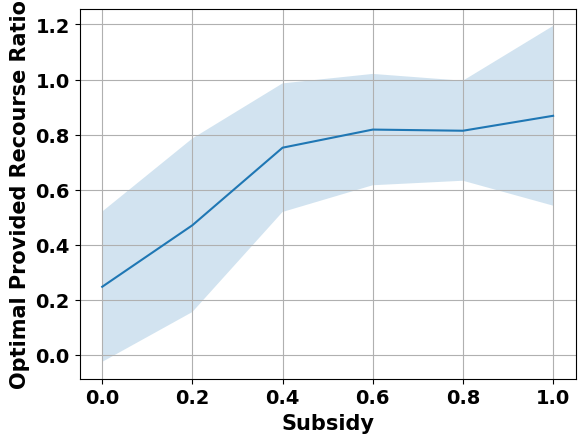

In [872]:
# Find the optimal ratio for each key (iteration, subsidy)
optimal_ratios = {}

for key, value in utility_result_dict.items():
    # Find the tuple with the maximum second quantity
    max_tuple = max(value, key=lambda x: x[1])
    # Get the first quantity corresponding to the maximum second quantity
    max_provided_rec_ratio = max_tuple[0]
    # Get the last first quantity in the value
    last_provided_rec_ratio = value[-1][0]
    # Calculate the normalized value
    normalized_value = max_provided_rec_ratio / last_provided_rec_ratio
    # Update the new dictionary
    optimal_ratios[key] = normalized_value
    
# Group the ratios by subsidy value
subsidy_values = {}
for key, ratio in optimal_ratios.items():
    _, subsidy = key
    if subsidy not in subsidy_values:
        subsidy_values[subsidy] = []
    subsidy_values[subsidy].append(ratio)

# Calculate the mean and standard deviation of the ratios for each subsidy
subsidies = sorted(subsidy_values.keys())
means = [np.mean(subsidy_values[subsidy]) for subsidy in subsidies]

std_devs = [np.std(subsidy_values[subsidy]) for subsidy in subsidies]

plt.plot(subsidies, means)
plt.fill_between(subsidies, [a - b for a, b in zip(means, std_devs)], [a + b for a, b in zip(means, std_devs)], alpha = 0.2)


plt.xlabel('Subsidy', fontsize=15, fontweight='bold')
plt.ylabel('Optimal Provided Recourse Ratio', fontsize=15, fontweight='bold')

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

plt.grid(True)

# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_max_utility_rec_provided_rate.png")

plt.show()


In [839]:
#optimal_ratios

In [842]:
#subsidy_values

<Figure size 640x480 with 0 Axes>

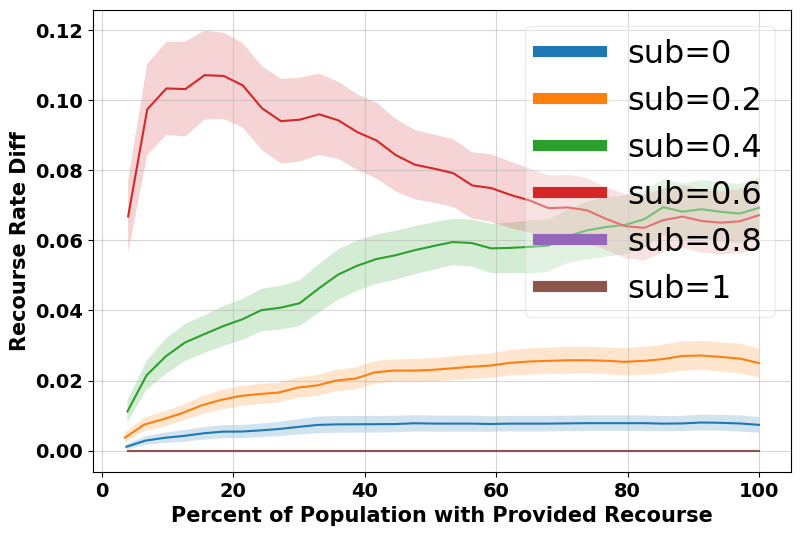

In [874]:
means, std_devs = calculate_mean_std(rec_ratio_diff_result_dict)

plt.figure()  # Create a new figure for each plot

#Plotting with normalized x-axis
plt.figure(figsize=(9, 6))

for sub, mean_values in means.items():
    # Normalizing x-values to percentage
    max_x_value = np.max(mean_values[:, 0])
    x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
    y_values = mean_values[:, 1]
    std_dev = std_devs[sub]

    plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
    plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# Customize the plot
#plt.title('Recourse Rate', fontsize=20, fontweight='bold')
plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
plt.ylabel('Recourse Rate Diff', fontsize=15, fontweight='bold')


# Adding and customizing the legend
legend = plt.legend(fontsize = 23, title_fontsize = 25, framealpha = 0.35, loc='upper right')# Set fontsize for legend labels and title

for line in legend.get_lines():
    line.set_linewidth(8)  # Set the linewidth of the line in the legend
    

# Setting x-axis to specific percentages
#percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
#plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# Customizing the x-axis and y-axis tick labels
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')



plt.grid('on', alpha = 0.5)

# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_rec_rate_diff.png")

plt.show()

<Figure size 640x480 with 0 Axes>

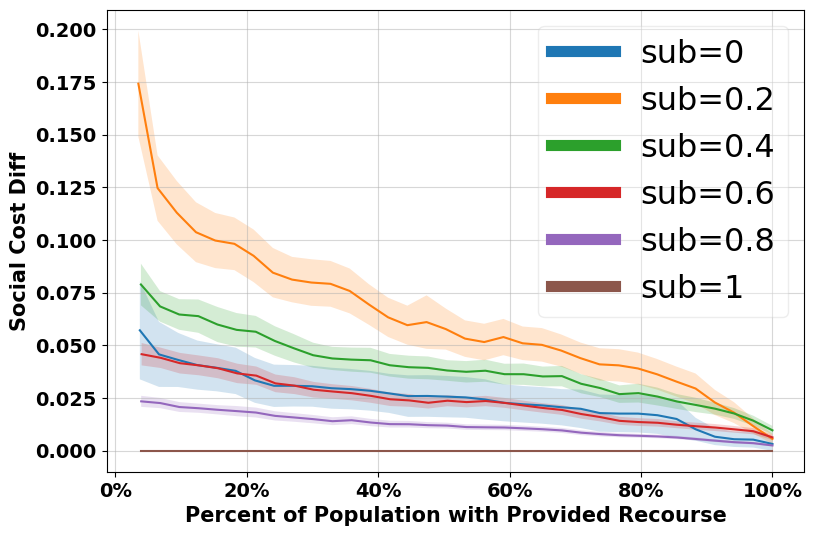

In [877]:
means, std_devs = calculate_mean_std(social_cost_diff_result_dict)


plt.figure()  # Create a new figure for each plot

#Plotting with normalized x-axis
plt.figure(figsize=(9, 6))

for sub, mean_values in means.items():
    # Normalizing x-values to percentage
    max_x_value = np.max(mean_values[:, 0])
    x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
    y_values = mean_values[:, 1]
    std_dev = std_devs[sub]

    plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
    plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# Customize the plot
#plt.title('Recourse Rate', fontsize=20, fontweight='bold')
plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
plt.ylabel('Social Cost Diff', fontsize=15, fontweight='bold')


# Adding and customizing the legend
legend = plt.legend(fontsize = 23, title_fontsize = 25, framealpha = 0.35, loc='upper right')# Set fontsize for legend labels and title

for line in legend.get_lines():
    line.set_linewidth(8)  # Set the linewidth of the line in the legend

plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    

# Setting x-axis to specific percentages
#percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
#plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# Customizing the x-axis and y-axis tick labels
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')


plt.grid('on', alpha = 0.5)

# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_social_cost_diff.png")

plt.show()

## [Figure 6.7]implementation for fixed reveal set, recourse rate diff as a function of subsidy

In [552]:
name = 'german'


In [554]:
print(name)
name_index = names.index(name)

sense_f = 'race' if name_index <= 3 else 'gender'
fileInfo = FileInfo(sense_f=sense_f)
X, y, A = fileInfo.prep(f_index=name_index + 1, groups=True, remove_sense=False, numpy= False, scaling='both', even_lables = True)


y = y.to_numpy()
A = A.to_numpy()
X = X.to_numpy()


X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(X, y, A, train_size=0.75)
clf = LRG(max_iter = 10_000).fit(X_train, y_train)

full_pred = clf.predict(X)
test_pred = clf.predict(X_test)

X_pos_full = X_test[test_pred == 1] # set of all positively classified features
y_pos_full = y_test[test_pred == 1] # get the corresponding y_pos_full
A_pos_full = A_test[test_pred == 1] # get the corresponding A_pos_full


X_neg_full = X_test[test_pred == 0] # set of all negatively classified features (these should be the agents)
y_neg_full = y_test[test_pred == 0] # get the corresponding y_neg
A_neg_full = A_test[test_pred == 0] # get the corresponding A_neg



# Concatenate the positive and negative datasets
X_combined = np.vstack((X_pos_full, X_neg_full))
y_combined = np.concatenate((y_pos_full, y_neg_full))

# Make predictions using the classifier
y_pred = clf.predict(X_combined)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_combined, y_pred)

# Extract the values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

print(tn, fp, fn, tp)

german
removed features: []
130 53 39 128


In [ ]:
num_samps_pos = 40


print("num_samps_pos", num_samps_pos)

# generate X_pos and X_opt
X_pos_index = np.random.choice(np.arange(X_pos_full.shape[0]), size = num_samps_pos, replace = False)
X_pos = X_pos_full[X_pos_index]
y_pos = y_pos_full[X_pos_index]



# also downsample X_neg for the adult dataset

num_samps_neg = 100

print("num_samps_neg", num_samps_neg)


X_neg_index = np.random.choice(np.arange(X_neg_full.shape[0]), size = num_samps_neg, replace = False)
X_neg = X_neg_full[X_neg_index]
y_neg = y_neg_full[X_neg_index]

In [ ]:
total_run = 50

subs_rec_diff_list = np.linspace(0, 1, 20)


# create a dictionary for each plot to generate plots with error bars

revealed_ratio_list = [0.2, 0.5, 0.8]



revealed_set_size_list = [int(ratio * len(X_opt)) for ratio in revealed_ratio_list]


rec_ratio_diff_sub_result_dict = {}


# iterate over multiple runs
for iteration in range(total_run):
    print(iteration)
    
    # generate coefficient
    # law
    w_R = cost_scaling_factor * np.random.uniform(0.3, 0.9, size = X_neg[0].shape[0])
    w_M = cost_scaling_factor * 0.65 * np.random.uniform(0.2 , 1, size = X_neg[0].shape[0])

    # Adult 
    # w_R = cost_scaling_factor * np.random.uniform(0.3, 0.9, size = X_neg[0].shape[0])
    # w_M = cost_scaling_factor * 0.75 * np.random.uniform(0 , 1, size = X_neg[0].shape[0])

    # German
    # w_R = cost_scaling_factor * np.random.uniform(0.1, 1, size = X_neg[0].shape[0])
    # w_M = cost_scaling_factor * 0.9 * np.random.uniform(0.2 , 1, size = X_neg[0].shape[0])
 
    # generate X_pos and X_opt
    X_pos_index = np.random.choice(np.arange(X_pos_full.shape[0]), size = num_samps_pos, replace = False)
    X_pos = X_pos_full[X_pos_index]
    y_pos = y_pos_full[X_pos_index]

    # generate the cost after down-sample
    X_pos_cR, X_pos_cM = get_all_costs(X_neg, X_pos, w_R, w_M)

    # compute the optimal recourse set and generate its corresponding cost dictionary
    X_opt, X_opt_cR, X_opt_cM, rec_list_dict = X_opt_set_cost(X_neg, X_pos, X_pos_cR, X_pos_cM)


    for sub in subs_rec_diff_list:
        rec_ratio_diff_result_list = []
      #  print("sub", sub)

        # adjust the cost for subsidy

        X_opt_cR_subs = {key: value * (1 - sub) for key, value in X_opt_cR.items()}   

        selected_subset_sequence = greedy_probablistic_pair_submodular_minimization(X_neg, X_opt, X_opt_cR_subs, X_opt_cM, 
                                                               probablistic_submodular_function, prob, len(X_opt)) 

        for revealed_size in revealed_set_size_list:

            selected_subset = selected_subset_sequence[: revealed_size]

            rec_ratio_diff = diff_recourse_access(selected_subset, X_opt_cR_subs, X_opt_cM, X_neg, A_neg)
    
            rec_ratio_diff_result_list.append(rec_ratio_diff)
        
        rec_ratio_diff_sub_result_dict[iteration, sub] = rec_ratio_diff_result_list

In [ ]:
rec_ratio_diff_sub_result_dict

In [ ]:
# Store dictionaries in a dictionary with their desired names as keys
dictionaries = {
    'rec_ratio_diff_sub_result_dict': rec_ratio_diff_sub_result_dict
}

# Save the dictionaries as pickle files
dataset_name = names
save_dictionaries_as_pickle(dictionaries, dataset_name, classifier_name)


## import the pickle file and plot

In [ ]:
#dataset_name = 'adult'  # Replace with your actual dataset name

revealed_ratio_list = [0.2, 0.5, 0.8]

# Load the dictionaries from pickle files
loaded_dictionaries = load_pickled_dictionaries(['rec_ratio_diff_sub_result_dict'], dataset_name, classifier_name)
rec_ratio_diff_sub_result_dict = loaded_dictionaries['rec_ratio_diff_sub_result_dict']

In [ ]:
means, std_devs = calculate_mean_std_recourse_rate_diff(rec_ratio_diff_sub_result_dict)

In [ ]:
# Plot the data

# Generate subsidy values
num_sub_values = len(means[0])
subsidy_values = np.linspace(0, 1, num_sub_values)

# Plotting
#plt.figure(figsize=(10, 6))

for i, (mean, std_dev) in enumerate(zip(means, std_devs)):
    plt.plot(subsidy_values, mean, label=f'Percent Rec Provided = {int(100 * revealed_ratio_list[i])}' + '%')
    plt.fill_between(subsidy_values, np.array(mean) - np.array(std_dev), np.array(mean) + np.array(std_dev), alpha=0.2)


# Customize the plot
#plt.title('Recourse Rate Difference with Different Subsidy', fontsize=15, fontweight='bold')
plt.xlabel('subsidy', fontsize=15, fontweight='bold')
plt.ylabel('Recourse Rate Diff', fontsize=15, fontweight='bold')


#plt.ylabel('Recourse Rate Difference')

# Customizing the x-axis and y-axis tick labels
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')

# Adding and customizing the legend
legend = plt.legend()
for line in legend.get_lines():
    line.set_linewidth(5)  # set the linewidth of the line in the legend

plt.grid('on', alpha = 0.5)



# Saving the plot
plt.savefig(f"{dataset_name}_{classifier_name}_rec_rate_diff_sub.png")

plt.show()


In [ ]:
# This is the code before making the change on changing the x axis to be # of recourse action given


# num_samps = int(0.1 * len(X_pos_full))

# total_run = 1

# #subs_list = [0, 0.2, 0.4, 0.6, 0.8, 1]

# subs_list = [0, 0.5, 1] 

# prob = 0.7


# # create a dictionary for each plot to generate plots with error bars

# rec_ratio_result_dict = {}
# man_ratio_result_dict = {}

# utility_result_dict = {}

# social_cost_result_dict = {}

# rec_ratio_diff_result_dict = {}
# social_cost_diff_result_dict = {}


# for iteration in range(total_run):
#     print(iteration)
    
#     # generate coefficient
#     # law
#     w_R = cost_scaling_factor * np.random.uniform(0.3, 0.9, size = X_neg[0].shape[0])
#     w_M = cost_scaling_factor * 0.65 * np.random.uniform(0.2 , 1, size = X_neg[0].shape[0])

#     # Adult 
#     # w_R = cost_scaling_factor * np.random.uniform(0.3, 0.9, size = X_neg[0].shape[0])
#     # w_M = cost_scaling_factor * 0.75 * np.random.uniform(0 , 1, size = X_neg[0].shape[0])

#     # # German
#     # w_R = cost_scaling_factor * np.random.uniform(0.1, 1, size = X_neg[0].shape[0])
#     # w_M = cost_scaling_factor * 0.9 * np.random.uniform(0.2 , 1, size = X_neg[0].shape[0])
 
#     # generate X_pos and X_opt
#     X_pos_index = np.random.choice(np.arange(X_pos_full.shape[0]), size = num_samps, replace = False)
#     X_pos = X_pos_full[X_pos_index]
#     y_pos = y_pos_full[X_pos_index]

#     # generate the cost after down-sample
#     X_pos_cR, X_pos_cM = get_all_costs(X_neg, X_pos, w_R, w_M)

#     # compute the optimal recourse set and generate its corresponding cost dictionary
#     #X_opt, X_opt_cR, X_opt_cM, rec_list_dict = X_opt_set_cost(X_neg, X_pos, X_pos_cR, X_pos_cM)
#     X_opt, X_opt_cR, X_opt_cM= X_opt_set_cost(X_neg, X_pos, X_pos_cR, X_pos_cM)
    
    
#     # generate one run over all subsidies
#     for sub in subs_list:
#         print("sub", sub)

#         # adjust the cost for subsidy

#         X_opt_cR_subs = {key: value * (1 - sub) for key, value in X_opt_cR.items()}   

#         # selected_subset_sequence = greedy_submodular_minimization(X_neg, X_opt, X_opt_cR_subs, X_opt_cM, 
#         #                                                        submodular_function, len(X_opt)) 

#         selected_subset_sequence = greedy_probablistic_pair_submodular_minimization(X_neg, X_opt, X_opt_cR_subs, X_opt_cM, 
#                                                                probablistic_submodular_function, prob, len(X_opt))  
#     #    provide_rec = np.zeros(len(X_neg))


#         # generate results
#         rec_ratio_result_list = []
#         man_ratio_result_list = []

#         utility_result_list = []

#         social_cost_result_list = []

#         rec_ratio_diff_result_list = []
#         social_cost_diff_result_list = []

#         for i in range(0, len(X_opt)-1):


#             selected_subset = selected_subset_sequence[:i+1]

#             #index = list(rec_list_dict(ele) for ele in selected_subset)
            
#             #provide_rec = [1 if ii in index else 0 for ii in range(len(X_neg))]
            
#             # print(selected_subset)

#             # recourse ratio, manipulation ratio, and system utility      
#             #rec_ratio, man_ratio, utility_result = compute_utils(selected_subset, X_opt, X_opt_cR_subs, X_opt_cM, clf, X_neg, y_neg, X_pos, y_pos, provide_rec)
#             rec_ratio, man_ratio, utility_result = compute_utils(selected_subset, X_opt, X_opt_cR_subs, X_opt_cM, clf, X_neg, y_neg, X_pos, y_pos)

#             # social cost
#             social_cost_result = social_cost(selected_subset, X_opt_cR_subs, X_opt_cM, X_neg)


#             # fairness disparity
#             rec_ratio_diff = diff_recourse_access(selected_subset, X_opt_cR_subs, X_opt_cM, X_neg, A_neg)
#             social_cost_diff = diff_social_cost_group(selected_subset, X_opt_cR_subs, X_opt_cM, X_neg, A_neg)



#             rec_ratio_result_list.append(rec_ratio)
#             man_ratio_result_list.append(man_ratio)

#             utility_result_list.append(utility_result)

#             social_cost_result_list.append(social_cost_result)

#             rec_ratio_diff_result_list.append(rec_ratio_diff)
#             social_cost_diff_result_list.append(social_cost_diff)
    
    
    
#         rec_ratio_result_dict[iteration, sub] = rec_ratio_result_list
#         man_ratio_result_dict[iteration, sub] = man_ratio_result_list

#         utility_result_dict[iteration, sub] = utility_result_list

#         social_cost_result_dict[iteration, sub] = social_cost_result_list

#         rec_ratio_diff_result_dict[iteration, sub] = rec_ratio_diff_result_list
#         social_cost_diff_result_dict[iteration, sub] = social_cost_diff_result_list
    
    

In [ ]:
# def generate_average_error(data):
#     # Initialize variables to store averages and standard deviations
#     averages = {}
#     errors = {}


#     # Separate data by 'sub' values
#     sub_data = {}

#     for (iteration, sub), values in data.items():
#         if sub not in sub_data:
#             sub_data[sub] = []
#         sub_data[sub].append(values)

#          # Normalize data length (e.g., interpolate to the length of the longest run)
#         max_length = max(len(sublist) for sublist in sub_data[sub])
#         sub_data[sub] = [np.interp(np.linspace(0, 1, max_length), np.linspace(0, 1, len(run)), run) for run in sub_data[sub]]

#         # Compute averages and error bars
#         for sub, values in sub_data.items():
#             avg = np.mean(values, axis=0)
#             std_dev = np.std(values, axis=0)
#             num_samples = len(values)
#             std_error = std_dev / np.sqrt(num_samples)

#             averages[sub] = avg
#             errors[sub] = std_error
            
#     return averages, errors


In [ ]:
# averages, errors = generate_average_error(rec_ratio_result_dict)

# # Plot the data
# for sub, average in averages.items():
#     std_dev = errors[sub]
#     iterations = list(range(1, len(average) + 1))
#     plt.plot(iterations, average, label=f'sub =  {sub}')
#     plt.fill_between(iterations, average - std_dev, average + std_dev, alpha=0.2)

# # Customize the plot
# plt.title('Recourse Rate', fontsize=20, fontweight='bold')
# plt.xlabel('Percent of Revealed Features', fontsize=15)



# # Adding and customizing the legend
# legend = plt.legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend



# # Setting x-axis to specific percentages
# percentage_ticks = np.linspace(min(iterations), max(iterations), 5)  # Five equally spaced values between min and max of x
# plt.xticks(percentage_ticks, ['20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# # Customizing the x-axis and y-axis tick labels
# plt.xticks(fontsize=14, fontweight='bold')
# plt.yticks(fontsize=14, fontweight='bold')




# plt.grid('on', alpha = 0.5)


# #save the plot as name_rec_rate.png


In [ ]:
# # Create a figure and 1x2 subplots
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))


# # recourse ratio

# average_rec_ratio, errors_rec_ratio = generate_average_error(rec_ratio_result_dict)

# # Plot the data
# for sub, average in average_rec_ratio.items():
#     std_dev = errors_rec_ratio[sub]
#     iterations = list(range(1, len(average) + 1))
#     axes[0].plot(iterations, average, label=f'sub =  {sub}')
#     axes[0].fill_between(iterations, average - std_dev, average + std_dev, alpha=0.2)

# # Customize the plot
# axes[0].set_title('Recourse Rate', fontsize=20, fontweight='bold')
# axes[0].set_xlabel('Percent of Revealed Recourse Actions', fontsize=15)
# axes[0].legend()

# # Adding and customizing the legend
# legend = axes[0].legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend



# # Setting x-axis to specific percentages
# percentage_ticks = np.linspace(min(iterations), max(iterations), 6)  # Five equally spaced values between min and max of x
# axes[0].set_xticks(percentage_ticks)
# axes[0].set_xticklabels(['1%','20%', '40%', '60%', '80%', '100%'])

# # Customizing the x-axis and y-axis tick labels
# for label in axes[0].get_xticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# for label in axes[0].get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# axes[0].grid('on', alpha = 0.5)

# # manipulation ratio

# average_man_ratio, errors_man_ratio = generate_average_error(man_ratio_result_dict)

# # Plot the data
# for sub, average in average_man_ratio.items():
#     std_dev = errors_man_ratio[sub]
#     iterations = list(range(1, len(average) + 1))
#     axes[1].plot(iterations, average, label=f'sub =  {sub}')
#     axes[1].fill_between(iterations, average - std_dev, average + std_dev, alpha=0.2)

    
# # Customize the plot
# axes[1].set_title('Manipulation Rate', fontsize=20, fontweight='bold')
# axes[1].set_xlabel('Percent of Revealed Recourse Actions', fontsize=15)
# axes[1].legend()

# # Adding and customizing the legend
# legend = axes[1].legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend



# # Setting x-axis to specific percentages
# percentage_ticks = np.linspace(min(iterations), max(iterations), 6)  # Five equally spaced values between min and max of x
# axes[1].set_xticks(percentage_ticks)
# axes[1].set_xticklabels(['1%', '20%', '40%', '60%', '80%', '100%'])

# # Customizing the x-axis and y-axis tick labels
# for label in axes[1].get_xticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# for label in axes[1].get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# axes[1].grid('on', alpha = 0.5)


# plt.show()

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # social cost 

# average_social_cost, errors_social_cost = generate_average_error(social_cost_result_dict)

# # Plot the data
# for sub, average in average_social_cost.items():
#     std_dev = errors_social_cost[sub]
#     iterations = list(range(1, len(average) + 1))
#     axes[0].plot(iterations, average, label=f'sub =  {sub}')
#     axes[0].fill_between(iterations, average - std_dev, average + std_dev, alpha=0.2)

# # Customize the plot
# axes[0].set_title('Social Cost', fontsize=20, fontweight='bold')
# axes[0].set_xlabel('Percent of Revealed Recourse Actions', fontsize=15)
# axes[0].legend()

# # Adding and customizing the legend
# legend = axes[0].legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend



# # Setting x-axis to specific percentages
# percentage_ticks = np.linspace(min(iterations), max(iterations), 6)  # Five equally spaced values between min and max of x
# axes[0].set_xticks(percentage_ticks)
# axes[0].set_xticklabels(['1%','20%', '40%', '60%', '80%', '100%'])

# # Customizing the x-axis and y-axis tick labels
# for label in axes[0].get_xticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# for label in axes[0].get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# axes[0].grid('on', alpha = 0.5)


# # system utility

# average_system_utility, errors_system_utility = generate_average_error(utility_result_dict)

# # Plot the data
# for sub, average in average_system_utility.items():
#     std_dev = errors_system_utility[sub]
#     iterations = list(range(1, len(average) + 1))
#     axes[1].plot(iterations, average, label=f'sub =  {sub}')
#     axes[1].fill_between(iterations, average - std_dev, average + std_dev, alpha=0.2)

    

# # Customize the plot
# axes[1].set_title('System Utility', fontsize=20, fontweight='bold')
# axes[1].set_xlabel('Percent of Revealed Recourse Actions', fontsize=15)
# axes[1].legend()

# # Adding and customizing the legend
# legend = axes[1].legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend



# # Setting x-axis to specific percentages
# percentage_ticks = np.linspace(min(iterations), max(iterations), 6)  # Five equally spaced values between min and max of x
# axes[1].set_xticks(percentage_ticks)
# axes[1].set_xticklabels(['1%','20%', '40%', '60%', '80%', '100%'])

# # Customizing the x-axis and y-axis tick labels
# for label in axes[1].get_xticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# for label in axes[1].get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# axes[1].grid('on', alpha = 0.5)


# plt.show()







In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# # rec ratio diff

# average_rec_ratio_diff, errors_rec_ratio_diff = generate_average_error(rec_ratio_diff_result_dict)

# # Plot the data
# for sub, average in average_rec_ratio_diff.items():
#     std_dev = errors_rec_ratio_diff[sub]
#     iterations = list(range(1, len(average) + 1))
#     axes[0].plot(iterations, average, label=f'sub =  {sub}')
#     axes[0].fill_between(iterations, average - std_dev, average + std_dev, alpha=0.2)

    
# # Customize the plot
# axes[0].set_title('Recourse Rate Difference', fontsize=20, fontweight='bold')
# axes[0].set_xlabel('Percent of Revealed Recourse Actions', fontsize=15)
# axes[0].legend()

# # Adding and customizing the legend
# legend = axes[0].legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend



# # Setting x-axis to specific percentages
# percentage_ticks = np.linspace(min(iterations), max(iterations), 6)  # Five equally spaced values between min and max of x
# axes[0].set_xticks(percentage_ticks)
# axes[0].set_xticklabels(['1%','20%', '40%', '60%', '80%', '100%'])

# # Customizing the x-axis and y-axis tick labels
# for label in axes[0].get_xticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# for label in axes[0].get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# axes[0].grid('on', alpha = 0.5)



# # social cost diff


# average_social_cost_diff, errors_social_cost_diff = generate_average_error(social_cost_diff_result_dict)

# # Plot the data
# for sub, average in average_social_cost_diff.items():
#     std_dev = errors_social_cost_diff[sub]
#     iterations = list(range(1, len(average) + 1))
#     axes[1].plot(iterations, average, label=f'sub =  {sub}')
#     axes[1].fill_between(iterations, average - std_dev, average + std_dev, alpha=0.2)

    
# # Customize the plot
# axes[1].set_title('Social Cost Difference', fontsize=20, fontweight='bold')
# axes[1].set_xlabel('Percent of Revealed Recourse Actions', fontsize=15)
# axes[1].legend()

# # Adding and customizing the legend
# legend = axes[1].legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend



# # Setting x-axis to specific percentages
# percentage_ticks = np.linspace(min(iterations), max(iterations), 6)  # Five equally spaced values between min and max of x
# axes[1].set_xticks(percentage_ticks)
# axes[1].set_xticklabels(['1%','20%', '40%', '60%', '80%', '100%'])

# # Customizing the x-axis and y-axis tick labels
# for label in axes[1].get_xticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# for label in axes[1].get_yticklabels():
#     label.set_fontsize(14)
#     label.set_fontweight('bold')

# axes[1].grid('on', alpha = 0.5)


# plt.show()



In [ ]:
# # plots 
# # rec_rate
# means, std_devs = calculate_mean_std(rec_ratio_result_dict)

# plt.figure()  # Create a new figure for each plot

# #Plotting with normalized x-axis
# plt.figure(figsize=(9, 6))

# for sub, mean_values in means.items():
#     # Normalizing x-values to percentage
#     max_x_value = np.max(mean_values[:, 0])
#     x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
#     y_values = mean_values[:, 1]
#     std_dev = std_devs[sub]

#     plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
#     plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# # Customize the plot
# #plt.title('Recourse Rate', fontsize=20, fontweight='bold')
# plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
# plt.ylabel('Recourse Rate', fontsize=15, fontweight='bold')


# # Adding and customizing the legend
# legend = plt.legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend

# plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    

# # Setting x-axis to specific percentages
# #percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
# #plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# # Customizing the x-axis and y-axis tick labels
# plt.xticks(fontsize=14, fontweight='bold')
# plt.yticks(fontsize=14, fontweight='bold')




# plt.grid('on', alpha = 0.5)

# # Saving the plot
# plt.savefig(f"{name}_rec_ratio_gbc.png")
# plt.show()


# # man_rate

# means, std_devs = calculate_mean_std(man_ratio_result_dict)

# plt.figure()  # Create a new figure for each plot

# #Plotting with normalized x-axis
# plt.figure(figsize=(9, 6))

# for sub, mean_values in means.items():
#     # Normalizing x-values to percentage
#     max_x_value = np.max(mean_values[:, 0])
#     x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
#     y_values = mean_values[:, 1]
#     std_dev = std_devs[sub]

#     plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
#     plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# # Customize the plot
# #plt.title('Recourse Rate', fontsize=20, fontweight='bold')
# plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
# plt.ylabel('Manipulation Rate', fontsize=15, fontweight='bold')


# # Adding and customizing the legend
# legend = plt.legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend

# plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    

# # Setting x-axis to specific percentages
# #percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
# #plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# # Customizing the x-axis and y-axis tick labels
# plt.xticks(fontsize=14, fontweight='bold')
# plt.yticks(fontsize=14, fontweight='bold')




# plt.grid('on', alpha = 0.5)



# # Saving the plot
# plt.savefig(f"{name}_man_ratio_gbc.png")

# plt.show()

# # utility

# means, std_devs = calculate_mean_std(utility_result_dict)

# plt.figure()  # Create a new figure for each plot

# #Plotting with normalized x-axis
# plt.figure(figsize=(9, 6))

# for sub, mean_values in means.items():
#     # Normalizing x-values to percentage
#     max_x_value = np.max(mean_values[:, 0])
#     x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
#     y_values = mean_values[:, 1]
#     std_dev = std_devs[sub]

#     plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
#     plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# # Customize the plot
# #plt.title('Recourse Rate', fontsize=20, fontweight='bold')
# plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
# plt.ylabel('System Utility', fontsize=15, fontweight='bold')


# # Adding and customizing the legend
# legend = plt.legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend

# plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    

# # Setting x-axis to specific percentages
# #percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
# #plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# # Customizing the x-axis and y-axis tick labels
# plt.xticks(fontsize=14, fontweight='bold')
# plt.yticks(fontsize=14, fontweight='bold')




# plt.grid('on', alpha = 0.5)


# # Saving the plot
# plt.savefig(f"{name}_utility_gbc.png")

# plt.show()


# #social cost


# means, std_devs = calculate_mean_std(social_cost_result_dict)

# plt.figure()  # Create a new figure for each plot
# #Plotting with normalized x-axis
# plt.figure(figsize=(9, 6))

# for sub, mean_values in means.items():
#     # Normalizing x-values to percentage
#     max_x_value = np.max(mean_values[:, 0])
#     x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
#     y_values = mean_values[:, 1]
#     std_dev = std_devs[sub]

#     plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
#     plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# # Customize the plot
# #plt.title('Recourse Rate', fontsize=20, fontweight='bold')
# plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
# plt.ylabel('Social Cost', fontsize=15, fontweight='bold')


# # Adding and customizing the legend
# legend = plt.legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend

# plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    

# # Setting x-axis to specific percentages
# #percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
# #plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# # Customizing the x-axis and y-axis tick labels
# plt.xticks(fontsize=14, fontweight='bold')
# plt.yticks(fontsize=14, fontweight='bold')




# plt.grid('on', alpha = 0.5)



# # Saving the plot
# plt.savefig(f"{name}_social_cost_gbc.png")

# plt.show()
# # recourse rate diff


# means, std_devs = calculate_mean_std(rec_ratio_diff_result_dict)
# plt.figure()  # Create a new figure for each plot

# #Plotting with normalized x-axis
# plt.figure(figsize=(9, 6))

# for sub, mean_values in means.items():
#     # Normalizing x-values to percentage
#     max_x_value = np.max(mean_values[:, 0])
#     x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
#     y_values = mean_values[:, 1]
#     std_dev = std_devs[sub]

#     plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
#     plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# # Customize the plot
# #plt.title('Recourse Rate', fontsize=20, fontweight='bold')
# plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
# plt.ylabel('Recourse Rate Diff', fontsize=15, fontweight='bold')


# # Adding and customizing the legend
# legend = plt.legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend

# plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    

# # Setting x-axis to specific percentages
# #percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
# #plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# # Customizing the x-axis and y-axis tick labels
# plt.xticks(fontsize=14, fontweight='bold')
# plt.yticks(fontsize=14, fontweight='bold')




# plt.grid('on', alpha = 0.5)



# # Saving the plot
# plt.savefig(f"{name}_rec_rate_diff_gbc.png")

# plt.show()

# ##################### social cost diff #####################

# means, std_devs = calculate_mean_std(social_cost_diff_result_dict)

# plt.figure()  # Create a new figure for each plot

# #Plotting with normalized x-axis
# plt.figure(figsize=(9, 6))

# for sub, mean_values in means.items():
#     # Normalizing x-values to percentage
#     max_x_value = np.max(mean_values[:, 0])
#     x_values_normalized = (mean_values[:, 0] / max_x_value) * 100
#     y_values = mean_values[:, 1]
#     std_dev = std_devs[sub]

#     plt.plot(x_values_normalized, y_values, label=f'sub={sub}')
#     plt.fill_between(x_values_normalized, y_values - std_dev, y_values + std_dev, alpha=0.2)

# # Customize the plot
# #plt.title('Recourse Rate', fontsize=20, fontweight='bold')
# plt.xlabel('Percent of Population with Provided Recourse', fontsize=15, fontweight='bold')
# plt.ylabel('Social Cost Diff', fontsize=15, fontweight='bold')


# # Adding and customizing the legend
# legend = plt.legend()
# for line in legend.get_lines():
#     line.set_linewidth(5)  # set the linewidth of the line in the legend

# plt.gca().xaxis.set_major_formatter(mticker.PercentFormatter())
    

# # Setting x-axis to specific percentages
# #percentage_ticks = np.linspace(min(mean_values[:, 0]), max(mean_values[:, 0]), 6)  # Five equally spaced values between min and max of x
# #plt.xticks(percentage_ticks, ['0%', '20%', '40%', '60%', '80%', '100%'])  # Setting the tick positions and labels

# # Customizing the x-axis and y-axis tick labels
# plt.xticks(fontsize=14, fontweight='bold')
# plt.yticks(fontsize=14, fontweight='bold')




# plt.grid('on', alpha = 0.5)



# # Saving the plot
# plt.savefig(f"{name}_social_cost_diff_gbc.png")

# plt.show()